In [ ]:
!pip3 install transformers
!pip3 install scikit-multilearn
!pip3 install iterative-stratification


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get install -y --no-install-recommends libcudnn8
!apt-mark hold libcudnn8

!nvcc --version
!echo "cudnn version:"
!cat /usr/local/cuda/include/cudnn_version.h | grep CUDNN_MAJOR -A 2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8 libcudnn8-dev
2 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
E: Held packages were changed and -y was used without --allow-change-held-packages.
libcudnn8 was already set on hold.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
cudnn version:
cat: /usr/local/cuda/include/cudnn_version.h: No such file or directory


In [ ]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import tensorflow as tf


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Load the dataset
df = pd.read_csv("./data_filtered.csv")
# df = df.drop(columns=['None', 'powerlabel'])
df.dropna(inplace=True)

# Convert labels to tensor
labels = df.iloc[:, 1:].values

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize input sentences and create attention masks
input_ids = []
attention_masks = []

for sentence in df['Content']:
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=387, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='tf')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert input_ids and attention_masks to tensors
input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)

# Prepare data for train-test split
X = np.hstack([input_ids.numpy(), attention_masks.numpy()])
y = labels

# Split the data into training and testing sets
train_X, test_X, train_y, test_y, train_index, test_index = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

train_input_ids, train_attention_masks = train_X[:, :387], train_X[:, 387:]
test_input_ids, test_attention_masks = test_X[:, :387], test_X[:, 387:]
train_labels, test_labels = train_y, test_y

# Define the path to save the model
model_path = "./trained_model"

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)

# Check if a saved model exists and load it, if it does
if os.path.exists(model_path):
    model = TFBertForSequenceClassification.from_pretrained(model_path)
else:
    # Initialize the model
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=labels.shape[1])

    # Compile the model for training
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = tf.keras.metrics.BinaryAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Train the model
    history = model.fit(
        [train_input_ids, train_attention_masks],
        train_labels,
        epochs=1,
        batch_size=2,
        validation_data=(
            [test_input_ids, test_attention_masks],
            test_labels
        ),
        callbacks=[early_stopping, model_checkpoint]
    )


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


15875/15876 [============================>.] - ETA: 0s - loss: 0.2036 - accuracy: 0.9218

15876/15876 [==============================] - 823s 49ms/step - loss: 0.2036 - accuracy: 0.9218 - val_loss: 0.1081 - val_accuracy: 0.9650


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Evaluate the model on the test set
predictions = model.predict([test_input_ids, test_attention_masks])
logits = predictions.logits  # Access the logits from the output object
threshold = 0.5
predicted_labels = (np.array(logits, dtype=float) >= threshold).astype(int)
true_labels = test_labels


249/249 [==============================] - 33s 117ms/step


In [ ]:
import pandas as pd

# Calculate metrics (precision, recall, F1 score)
label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0, target_names=label_names)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the classification report as a table
print("Classification report:")
print(report_df)


Classification report:
              precision    recall  f1-score  support
symptom_1      0.991457  0.950843  0.970726   2075.0
symptom_2      0.984367  0.968221  0.976227   1951.0
symptom_3      0.995489  0.889785  0.939674   2232.0
symptom_4      0.950704  0.815163  0.877732   2981.0
symptom_5      0.985947  0.844988  0.910042   2574.0
symptom_6      0.992721  0.925849  0.958119   1915.0
symptom_7      0.952164  0.950000  0.951081   2200.0
micro avg      0.977402  0.898795  0.936451  15928.0
macro avg      0.978979  0.906407  0.940514  15928.0
weighted avg   0.977361  0.898795  0.935608  15928.0
samples avg    0.534497  0.526167  0.527518  15928.0


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, hamming_loss, jaccard_score

# Micro-averaged precision, recall, and F1 score
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')
print("Micro-averaged Precision:", micro_precision)
print("Micro-averaged Recall:", micro_recall)
print("Micro-averaged F1 score:", micro_f1)

# Macro-averaged precision, recall, and F1 score
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 score:", macro_f1)

# Hamming Loss
hamming = hamming_loss(true_labels, predicted_labels)
print("Hamming Loss:", hamming)

# Jaccard Score
jaccard = jaccard_score(true_labels, predicted_labels, average='samples')
print("Jaccard Score:", jaccard)


Micro-averaged Precision: 0.9774015156687377
Micro-averaged Recall: 0.8987945755901557
Micro-averaged F1 score: 0.9364513491414554
Macro-averaged Precision: 0.978978525884325
Macro-averaged Recall: 0.9064070500970525
Macro-averaged F1 score: 0.9405143271682277
Hamming Loss: 0.03496742612388871
Jaccard Score: 0.521695221298396


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


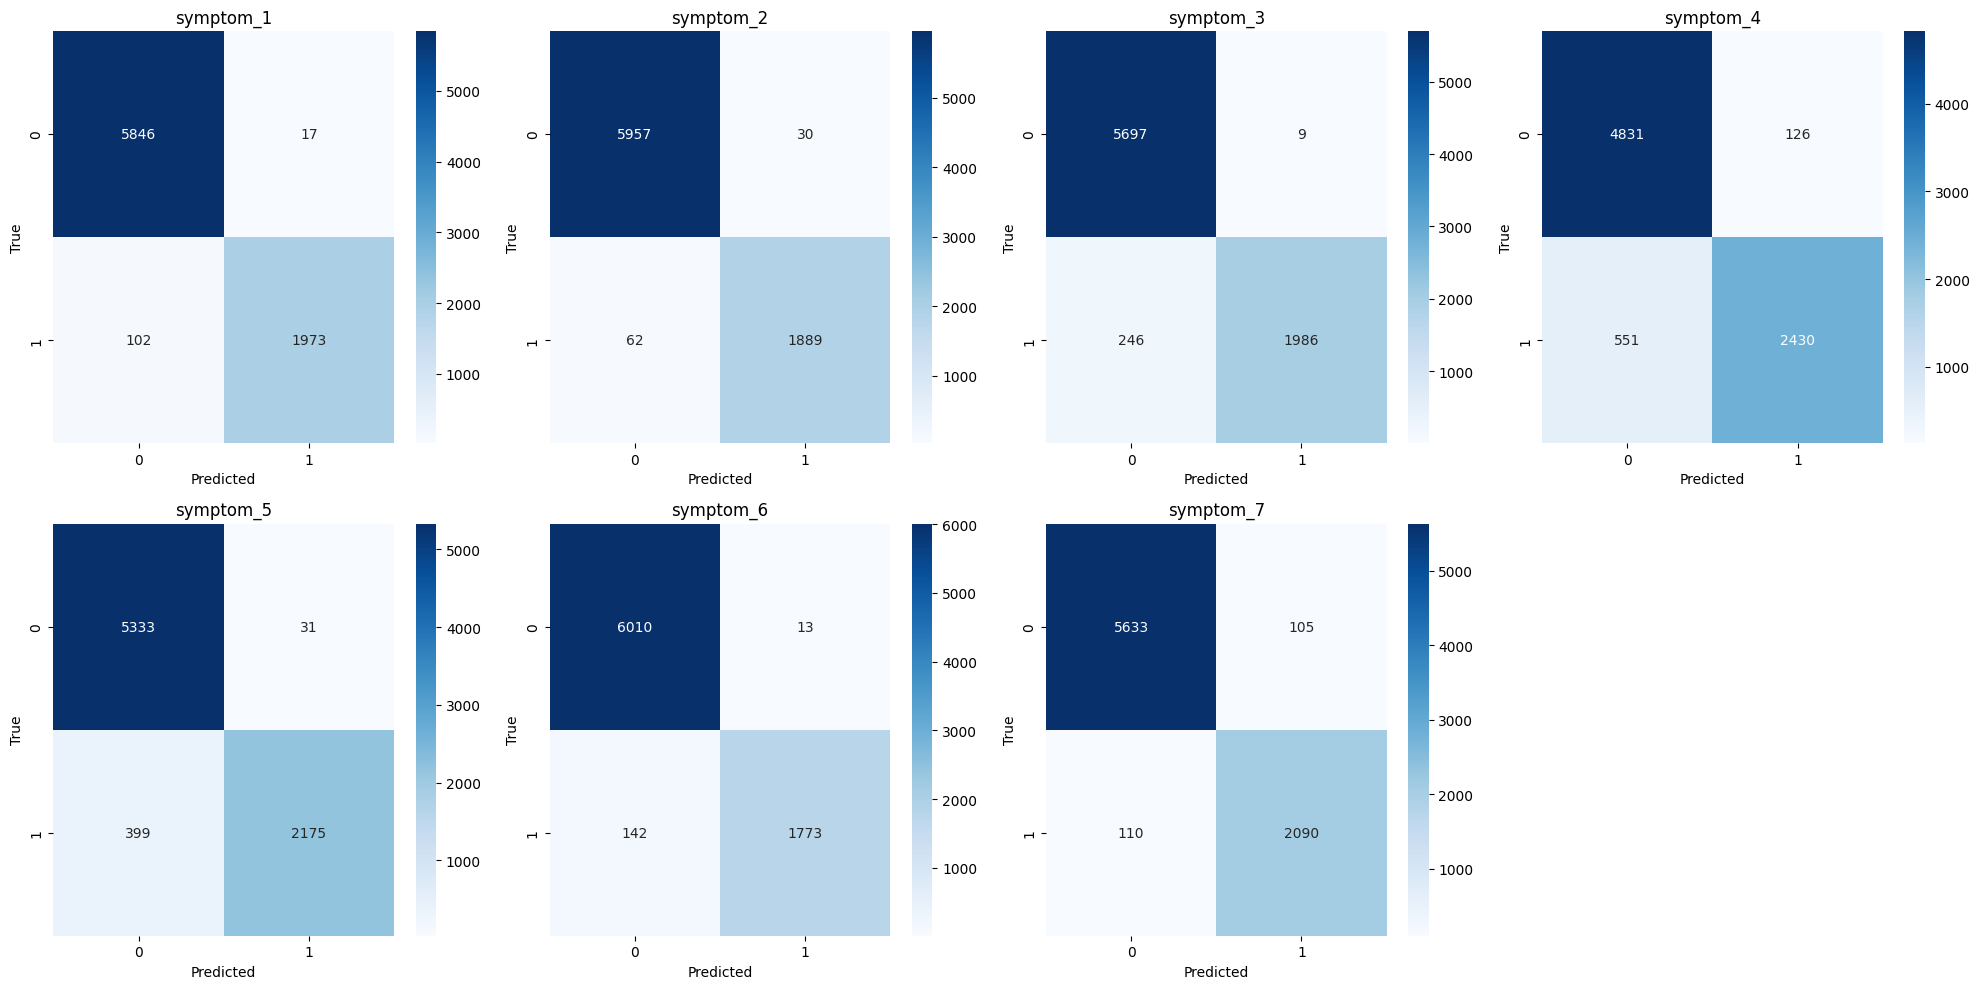

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import matplotlib.pyplot as plt


# Calculate the confusion matrix
# Since this is a multi-label classification problem, we'll use multilabel_confusion_matrix
cm = multilabel_confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
# label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']

# Create a grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.delaxes(axes[1, 3])  # remove the last subplot (as we have only 7 labels)

for i, (label_name, ax) in enumerate(zip(label_names, axes.flat)):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{label_name}')

plt.tight_layout()
plt.show()

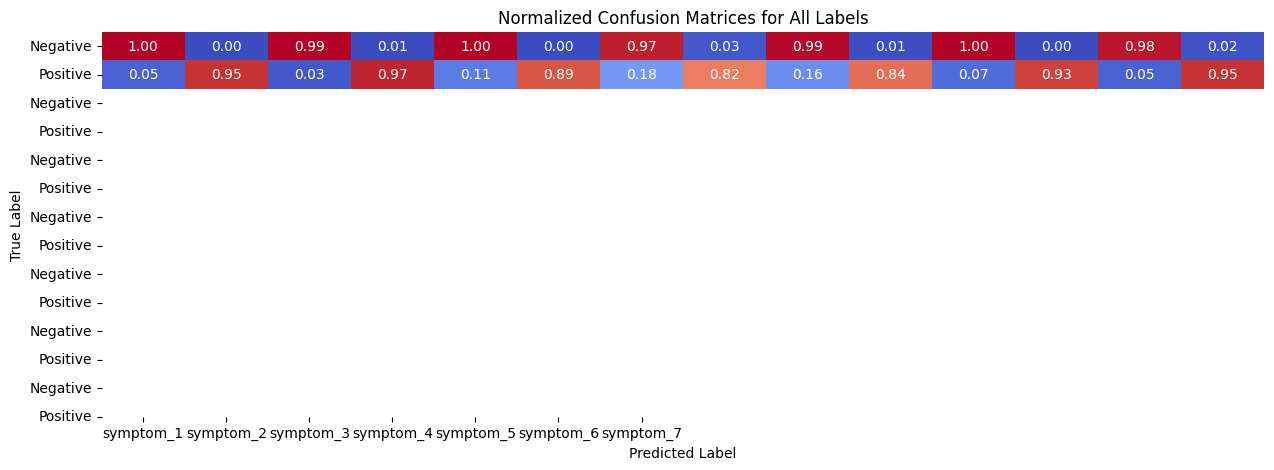

In [ ]:
# Create an empty list to store the normalized confusion matrices for each label
confusion_matrices = []

# Calculate the confusion matrices for each label and normalize them
for i in range(7):
    cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    confusion_matrices.append(cm_normalized)

# Combine the normalized confusion matrices into a single array
combined_cm = np.concatenate(confusion_matrices, axis=1)

# Plot the heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(combined_cm, annot=True, cmap="coolwarm", fmt=".2f", cbar=False, xticklabels=label_names, yticklabels=["Negative", "Positive"] * 7)

plt.title("Normalized Confusion Matrices for All Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


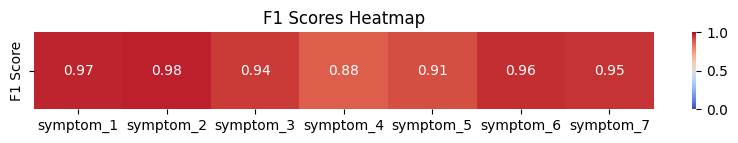

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics (precision, recall, F1 score)
label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0, target_names=label_names)

# Extract F1 scores for each label
f1_scores = {label: report[label]['f1-score'] for label in label_names}

# Create a heatmap of F1 scores
f1_scores_matrix = np.array(list(f1_scores.values())).reshape(1, -1)
plt.figure(figsize=(10, 1))
sns.heatmap(f1_scores_matrix, annot=True, fmt='.2f', xticklabels=label_names, yticklabels=['F1 Score'], cmap='coolwarm', vmin=0, vmax=1)
plt.title('F1 Scores Heatmap')
plt.show()


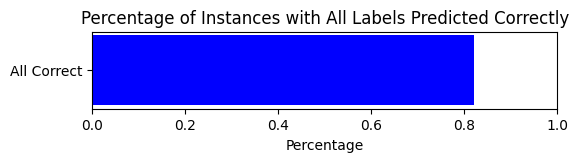

Exact Match Ratio: 0.82


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def all_correct_percentage(y_true, y_pred):
    correct = np.all(y_true == y_pred, axis=1)
    percentage = np.sum(correct) / len(correct)
    return percentage

# Calculate the percentage of instances with all labels predicted correctly
all_correct_pct = all_correct_percentage(true_labels, predicted_labels)

# Visualize the percentage
fig, ax = plt.subplots(figsize=(6, 1))
ax.barh(['All Correct'], [all_correct_pct], color='blue')
ax.set_xlim(0, 1)
ax.set_xlabel('Percentage')
ax.set_title('Percentage of Instances with All Labels Predicted Correctly')
plt.show()

def exact_match_ratio(true_labels, predicted_labels):
    assert true_labels.shape == predicted_labels.shape
    return np.all(true_labels == predicted_labels, axis=1).mean()

exact_match = exact_match_ratio(true_labels, predicted_labels)
print(f"Exact Match Ratio: {exact_match:.2f}")


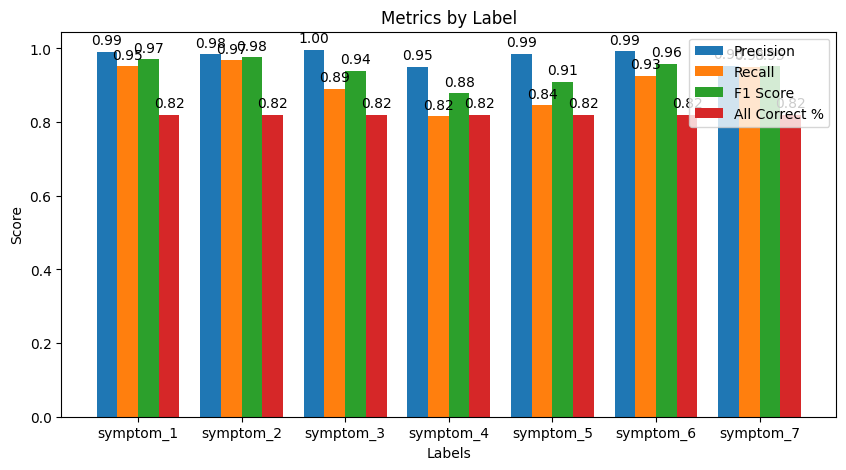

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract precision, recall, and F1 score from the classification report
precision = [report[label]['precision'] for label in label_names]
recall = [report[label]['recall'] for label in label_names]
f1_score = [report[label]['f1-score'] for label in label_names]

# Calculate the percentage of instances with all labels predicted correctly
all_correct_pct = all_correct_percentage(true_labels, predicted_labels)

# Visualize the metrics together
fig, ax = plt.subplots(figsize=(10, 5))
labels = np.arange(len(label_names))
width = 0.2

rects1 = ax.bar(labels - 1.5 * width, precision, width, label='Precision')
rects2 = ax.bar(labels - 0.5 * width, recall, width, label='Recall')
rects3 = ax.bar(labels + 0.5 * width, f1_score, width, label='F1 Score')
rects4 = ax.bar(labels + 1.5 * width, [all_correct_pct] * len(labels), width, label='All Correct %')

ax.set_xlabel('Labels')
ax.set_xticks(labels)
ax.set_xticklabels(label_names)
ax.set_ylabel('Score')
ax.set_title('Metrics by Label')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()


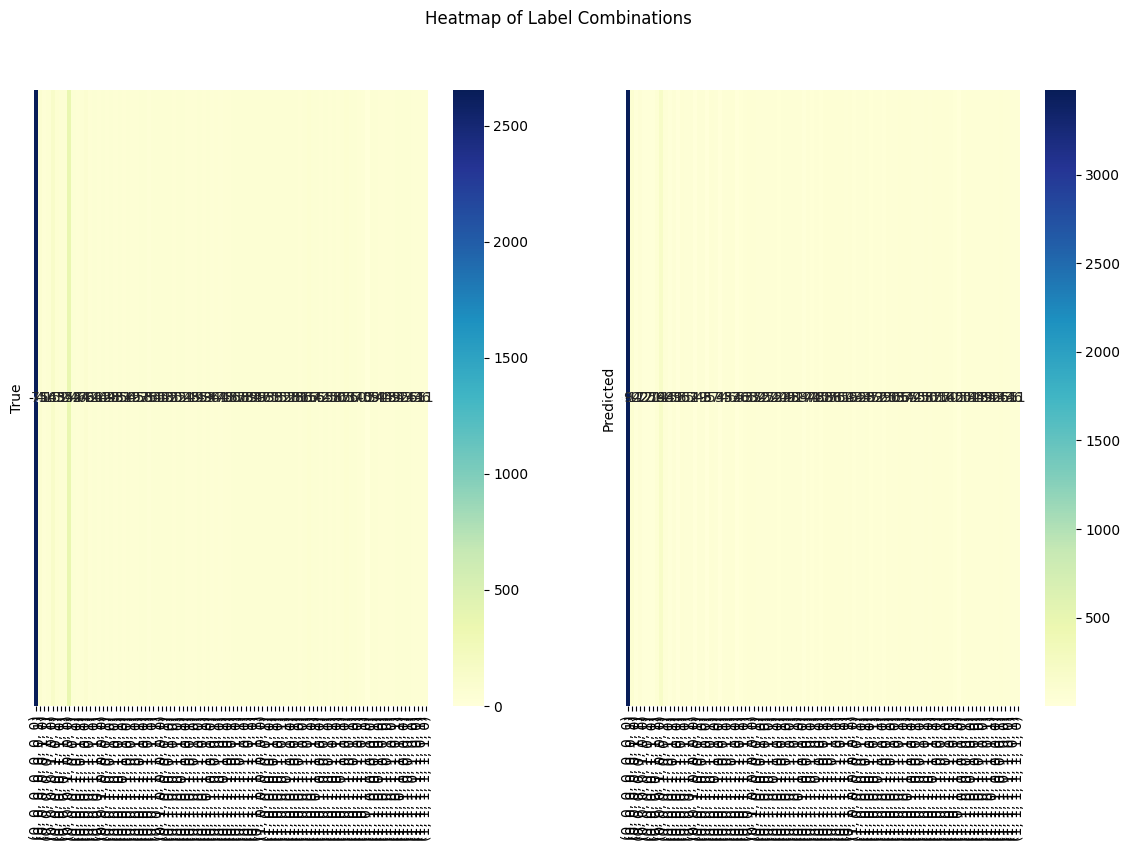

In [ ]:
import seaborn as sns
from collections import Counter

def label_combination_counts(labels):
    label_counts = Counter()
    for row in labels:
        label_counts[tuple(row)] += 1
    return label_counts

true_label_counts = label_combination_counts(true_labels)
predicted_label_counts = label_combination_counts(predicted_labels)

label_combinations = sorted(set(list(true_label_counts.keys()) + list(predicted_label_counts.keys())))
true_label_freq = [true_label_counts[combination] for combination in label_combinations]
predicted_label_freq = [predicted_label_counts[combination] for combination in label_combinations]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
fig.suptitle('Heatmap of Label Combinations')

sns.heatmap([true_label_freq], xticklabels=label_combinations, yticklabels=["True"], annot=True, fmt="d", cmap="YlGnBu", ax=ax1)
sns.heatmap([predicted_label_freq], xticklabels=label_combinations, yticklabels=["Predicted"], annot=True, fmt="d", cmap="YlGnBu", ax=ax2)

plt.show()


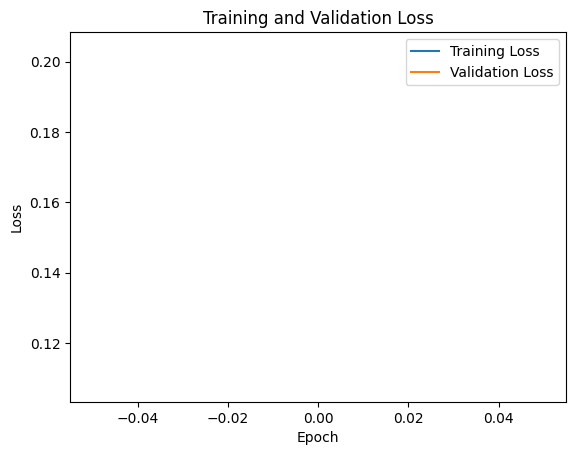

In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

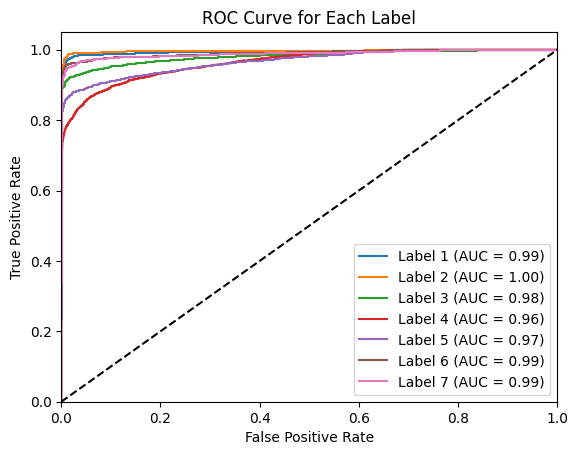

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calculate ROC curve and AUC for each label

n_classes = train_labels.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Rest of the code remains the same


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Label {i + 1} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Label')
plt.legend(loc="lower right")
plt.show()

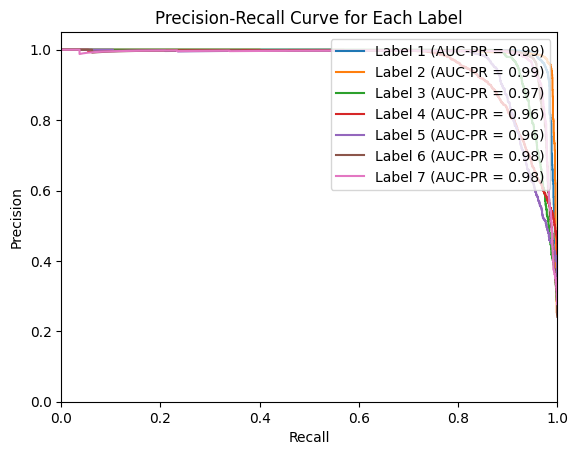

In [ ]:
# Calculate Precision-Recall curve and AUC-PR for each label
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels[:, i], logits[:, i])
    average_precision[i] = average_precision_score(true_labels[:, i], logits[:, i])

# Plot Precision-Recall curve
plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Label {i + 1} (AUC-PR = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Label')
plt.legend(loc="upper right")
plt.show()

In [ ]:
from transformers import TFBertModel

# Get the attention weights from BERT
def get_attention_weights(input_ids, attention_masks):
    bert = TFBertModel.from_pretrained('bert-base-uncased', output_attentions=True)
    outputs = bert(input_ids, attention_mask=attention_masks)
    attentions = outputs.attentions
    return attentions

# Analyze the attention weights for a specific sample
sample_index = 0  # Change this to analyze different samples
input_id_sample = test_input_ids[sample_index].reshape(1, -1)
attention_mask_sample = test_attention_masks[sample_index].reshape(1, -1)

# Convert tensors to the appropriate format
input_id_sample = tf.convert_to_tensor(input_id_sample)
attention_mask_sample = tf.convert_to_tensor(attention_mask_sample)

attentions = get_attention_weights(input_id_sample, attention_mask_sample)

# Get the words from the input_ids
tokens = tokenizer.convert_ids_to_tokens(input_id_sample[0])

# Print the attention weights for the sample
for i, attention in enumerate(attentions):
    print(f"Layer {i + 1}")
    print(tokens)
    print(attention[0][0].numpy())
    print("\n")


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Layer 1
['[CLS]', 'at', 'least', 'i', 'know', 'i', 'this', ',', 'i', 'would', 'basically', 'completed', 'hardest', 'thing', 'i', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [ ]:
'''qualitative example'''
# Define indices of examples to examine
example_indices = [0, 1, 2, 3, 4, 5, 6]

# Convert the predicted probabilities to binary labels
test_predictions = model.predict([test_input_ids, test_attention_masks])
test_binary_predictions = (np.array(test_predictions.logits, dtype=float) >= 0.5).astype(int)

# Define label names
label_names = ['happiness', 'love', 'enthusiasm', 'fun', 'surprise', 'neutral', 'sadness']

# Choose some examples to examine in more detail
for i in example_indices:
    # Get the input text and true label for the example
    input_text = df['Content'].iloc[test_index[i]]
    true_label = test_labels[i]

    # Get the predicted label for the example
    predicted_label = test_binary_predictions[i]

    # Map the predicted label indices to their names
    predicted_label_names = [label_names[j] for j, label in enumerate(predicted_label) if label == 1]

    # Print the input text, true label, and predicted label
    print("Input text:", input_text)
    print("True label:", true_label)
    print("Predicted label:", predicted_label)

   


249/249 [==============================] - 29s 116ms/step
Input text: At least I know I this, I would basically completed hardest thing I
True label: [0 0 0 0 0 1 0]
Predicted label: [0 0 0 0 0 0 0]
Input text: want stop thinking terribly myself. perhaps sincerely better dead. want happy everyone care about. want happy all. get sad. always think one appreciates bull going irl. irl, severely bullied, always assume everyone else going tell snitch unmatchable day well. know. .. really need better mental health, sentence improve, everyone going sick me. one stay long. completely disregarded time improved. feel like one willing stay me. feel bad people deal emotion
True label: [0 0 1 1 0 0 1]
Predicted label: [0 0 1 1 0 0 1]
Input text: I claim Zoloft 50mg Dextroamphetamine 15mg. At old school learned social science, I still shit social interaction. I aspergers, affect social life. I seeing psychyrachist clue fuck spell since 2nd grade. Funny thing, I sit off everyone I annoying shit. Only 

In [ ]:
# Error analysis
predictions = model.predict([test_input_ids, test_attention_masks])
logits = predictions.logits
threshold = 0.5
predicted_labels = (np.array(logits, dtype=float) >= threshold).astype(int)
true_labels = test_labels



249/249 [==============================] - 29s 116ms/step


In [ ]:
errors = []
for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)):
    if not np.array_equal(pred, true):
        errors.append(i)

print(f"Total errors: {len(errors)}")



# Inspect a specific error
for i in range(1000):
  error_index = errors[i]  # Change this to analyze different errors
  error_df_index = test_index[error_index]  # Get the index in the original dataframe
  print(f"Error {error_index}")
  print("Content: ", df.iloc[error_df_index]['Content'])  # Print the content of the misclassified sample
  print("True labels: ", true_labels[error_index])
  print("Predicted labels: ", predicted_labels[error_index])
  error_content = df.iloc[error_df_index]['Content']
  print(f"Content: {error_content}")

Streaming output truncated to the last 5000 lines.
Error 0
Content:  At least I know I this, I would basically completed hardest thing I
True labels:  [0 0 0 0 0 1 0]
Predicted labels:  [0 0 0 0 0 0 0]
Content: At least I know I this, I would basically completed hardest thing I
Error 4
Content:  everyone different! many people find person therapy beneficial others prefer online therapy multiple reasons.
True labels:  [0 0 0 1 0 0 0]
Predicted labels:  [0 0 0 0 0 0 0]
Content: everyone different! many people find person therapy beneficial others prefer online therapy multiple reasons.
Error 7
Content:  But I fail fail cry hurt physical pain much emotional pain worse
True labels:  [0 0 0 1 0 0 1]
Predicted labels:  [0 0 0 1 0 0 0]
Content: But I fail fail cry hurt physical pain much emotional pain worse
Error 15
Content:  Hello Care know I became psychopath since I feel bad anything anymore, I know exactly problem, I lost feeling towards anything, I see somebody getting shoot infornt Ato

In [ ]:
error_content = df.iloc[error_df_index]['Content']
print(f"Content: {error_content}")

Content: It might patronage, I 23 I dead 2 day before. Information technology deserving it. Just everything around seems dark, mingy light end. You might see people care are. You young many people meet. Find person cares. Everyone start stranger hope gogy
